# Imports and Loading data

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster
from folium import IFrame
from geopy.distance import great_circle
import plotly.express as px
import semfunction as sf
import numpy as np

# Get the current directory (analyses folder)
current_dir = os.getcwd()

# Navigate up one directory to reach the parent directory (which contains the data folder)
parent_dir = os.path.dirname(current_dir)

# Define the file paths relative to the parent directory using os.path.join
clean_huis_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_house.csv")
clean_apartement_te_koop_path = os.path.join(parent_dir, "data", "cleaned", "clean_app.csv")

house = pd.read_csv(clean_huis_te_koop_path, sep=",")
app = pd.read_csv(clean_apartement_te_koop_path, sep=",")

# Questions to answer

- How many observations and features do you have?
- What is the proportion of missing values per column?
- Which variables would you delete and why?
- What variables are most subject to outliers?
- How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?
- What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?
- How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?
- How are the number of properties distributed according to their surface?
- Which five variables do you consider the most important and why?
- What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

# Q1 How many observations and features do you have?

In [11]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

# Define function to count non-null values in each column
def count_non_null_values(df):
    return df.notnull().sum()

# Get colors from px.colors.qualitative.swatches()
colors = px.colors.qualitative.swatches()

# Create figure with subplots
fig = make_subplots(rows=2, cols=2, subplot_titles=("Number of Observations - Houses", 
                                                    "Number of Observations - Apartments", 
                                                    "Features and occurrences - Houses", 
                                                    "Features and occurrences - Apartments"))

# Plot 1: Number of observations for house dataset
fig.add_trace(go.Bar(x=['House'], y=[len(house)], marker=dict(color=px.colors.qualitative.T10[4])), row=1, col=1)

# Plot 2: Number of observations for apartment dataset
fig.add_trace(go.Bar(x=['Apartment'], y=[len(app)], marker=dict(color=px.colors.qualitative.T10[9])), row=1, col=2)

# Plot 3: Number of non-null values for each feature in house dataset
count_house = count_non_null_values(house)
fig.add_trace(go.Bar(x=count_house.index, y=count_house.values, marker=dict(color=px.colors.qualitative.T10[4])), row=2, col=1)

# Plot 4: Number of non-null values for each feature in apartment dataset
count_apartment = count_non_null_values(app)
fig.add_trace(go.Bar(x=count_apartment.index, y=count_apartment.values, marker=dict(color=px.colors.qualitative.T10[9])), row=2, col=2)

# Update layout
fig.update_layout(height=600, width=1200, showlegend=False,)

# Set the same y-axis range for Plot 1 and Plot 2
max_observation_value = max(len(house), len(app))
fig.update_yaxes(range=[0, max_observation_value], row=1, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=1, col=2)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=1)
fig.update_yaxes(range=[0, max_observation_value], row=2, col=2)


# Show plot
fig.show()

- For the `houses` we have 12397 observations and 25 features
- For the `apartments` we have 9468 observations and 24 features (as surface of good is always empty for apartments)


# Q2 What is the proportion of missing values per column?

In [14]:
def make_bar_perc_plotly(df):
    df_missing = pd.DataFrame()
    df_missing["not-missing"] = df.count()/len(df)*100
    df_missing["missing"] = df.isnull().sum()/len(df)*100

    fig = px.bar(df_missing, x=df_missing.index, y=df_missing.columns, title="Missing Values Proportion")
    fig.show()

make_bar_perc_plotly(house)

In [15]:
make_bar_perc_plotly(app)

# Q3 Which variables would you delete and why?


- surface_of_good for apartments
- property_id 
- property_type
- terrace
- garden

# Q4 What variables are most subject to outliers?


# Q5 How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?


# Q6 What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?

`Anwser`: The price exhibits a significant correlation with the living area and terrace area. This correlations can be attributed to the logical influence of price on the living space of a house. The price has no correlation with number of facades, surface of goods and number of rooms. The reason price and living area are better correlated is because if the house is bigger the price goes up. It also importend to note in which state the house is.


Text(0.5, 1.0, 'Correlations of houses')

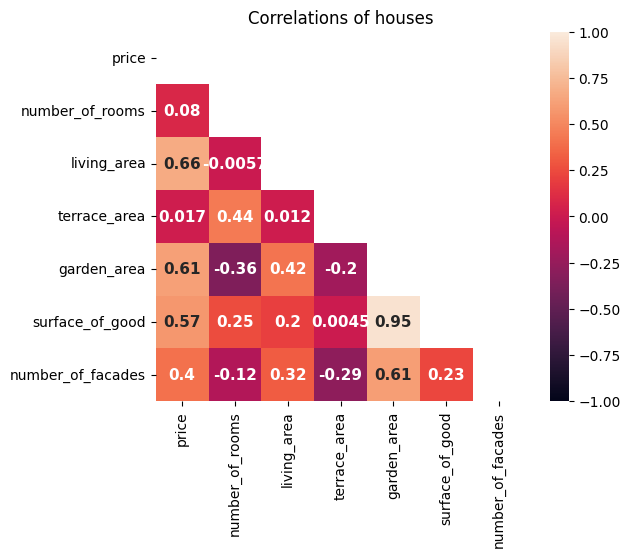

In [14]:
limburg = house[house["province"]=="limburg"]
limburg = limburg[limburg["state_of_building"]=="GOOD"]
limburgcorr = sf.drop_object_columns(limburg)
mask = np.triu(np.ones_like(limburgcorr.corr()))
sns.heatmap(limburgcorr.corr(), annot=True, vmin=-1, vmax=1, annot_kws={"fontsize":11, "fontweight":"bold"}, square=True, mask=mask).set_title("Correlations of houses") 

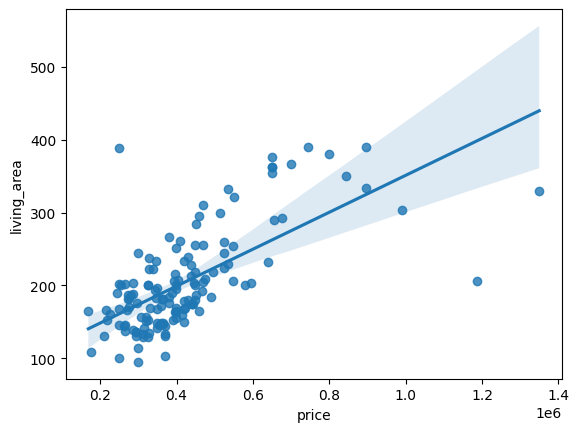

In [15]:
sf.regplot(limburgcorr, "price", "living_area")

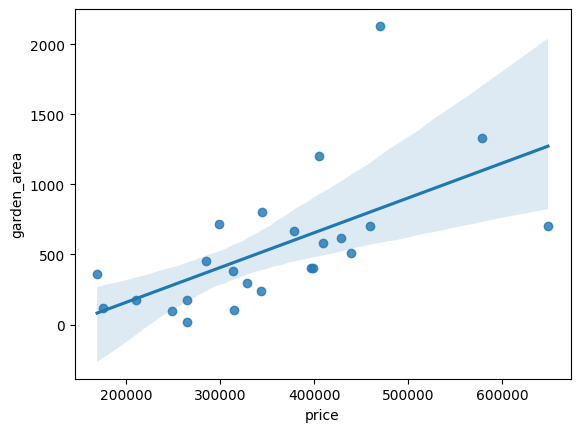

In [19]:
sf.regplot(limburgcorr, "price", "garden_area")

# Q7 How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?

`Anwser`: There exist correlations beyond just price, notably in the linear relationships between living area and terrace space and garden area and the overall land size(surface area). As the living area within a house expands, so does the corresponding terrace area. The garden area also expands.


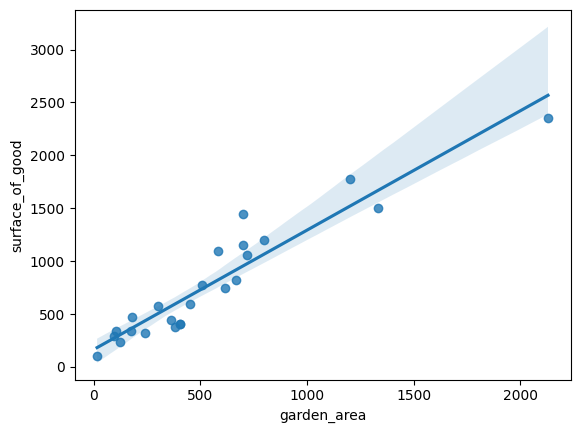

In [20]:
sf.regplot(limburgcorr, "garden_area", "surface_of_good")

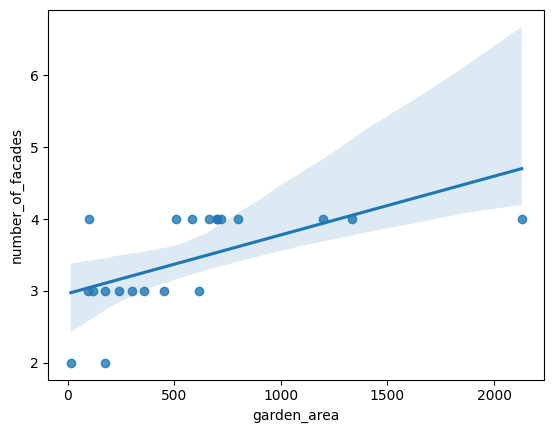

In [21]:
sf.regplot(limburgcorr, "garden_area", "number_of_facades")

# Q8 How are the number of properties distributed according to their surface?


# Q9 Which five variables do you consider the most important and why?


# Q10 What are the least/most expensive municipalities in Belgium/Wallonia/Flanders? (in terms of price per m², average price, and median price)

In [25]:
def aggregate_function(df):
    
    grouped = df.groupby('province').agg(
    mean_price=pd.NamedAgg(column='price', aggfunc='mean'),
    median_price=pd.NamedAgg(column='price', aggfunc='median'),
    max_price=pd.NamedAgg(column='price', aggfunc='max'),
    min_price=pd.NamedAgg(column='price', aggfunc='min'),

    mean_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='mean'),
    median_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='median'),
    max_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='max'),
    min_price_m2=pd.NamedAgg(column='price_per_m2', aggfunc='min'),

    lat=pd.NamedAgg(column='latitude', aggfunc='mean'),
    long = pd.NamedAgg(column='longitude', aggfunc='mean')
    

    ).reset_index()
    return grouped
house["price_per_m2"] = house["price"]/house["living_area"]
house_grouped = aggregate_function(house)

In [26]:
def make_map(df):
    # Define a custom marker icon

    map_center  = [df["lat"].mean(), df["long"].mean()]

    # Create the map
    my_map = folium.Map(location=map_center, zoom_start=8)

    for index, row in house_grouped.iterrows():
        Provincie, mean_price, median_price, max_price, min_price, mean_price_m2, median_price_m2, max_price_m2, min_price_m2, lat, long = row
        location_coordinates = [lat, long]
        popup = f"Province: {Provincie}\nMean Price: {round(mean_price,2)} EUR"
        custom_icon = folium.Icon(icon='home', prefix='fa')
        folium.Marker(location_coordinates, 
                    tooltip=popup,
                    icon= custom_icon).add_to(my_map)
        folium.CircleMarker(
            location=location_coordinates,
            radius=mean_price / 100000,  # Adjust the scaling factor as needed
            color='red',
            fill=True,
            fill_color='red'
        ).add_to(my_map)
    # Display the new map
    return my_map


In [27]:
make_map(house_grouped)